## Продуктовая аналитика

### Анализ клиентского пути в приложении - построение воронок

В файле data.tsv представлены логи пользователей для стартапа по автоматической генерации рекламных объявлений.

Путь пользователя:
1. Пользователь заходит на Landing-page, на которой представлена основная информация о продукте.
2. Если его заинтересовал продукт, ему нужно зарегестрироваться, чтобы им воспользоваться.
3. Далее он попадает в Личный Кабинет, где может указать URL своего сайта и запустить для него генерацию рекламных объявлений.
4. Когда пользователь запускает генерацию, мы прокачиваем информацию с его сайта и подаем на вход генеративным нейросетям.
5. Когда генерация закончена, мы показываем готовые рекламные объявления пользователю. Далее пользователь использует эти объявления на рекламных площадках для продвижения своего бизнеса.
6. Пользователю предлагается 3 бесплатных генерации, после чего ему предлагается опатить сервис, чтобы пользоваться дальше.

События
* event_timestamp - время, когда произошло событие в формате datetime
* user_id - уникальные идентификатор пользователя
* event_name - тип события. Существуют следующие типы:
    * visit_landing - посещение лендинга
    * visit_cabinet - посещение ЛК
    * generate - запуск генерации рекламного объявления
    * results_shown - пользователь увидел результаты генерации
    * payment - пользователь оплатил сервис
* traffic_name - для событий **event_name = visit_landing** в этом поле записывается Маркетинговый канал с которого мы привлекли пользователя на наш сервис
* generation_time - для событий **event_name = generate** время в секундах, сколько длилась генерация. Если поле пустое, то генерация по каким-то причинам упала с ошибкой

Отрисуем воронку уникальных пользователей по основным этапам
* Пришел на лендинг
* Зарегистрировался
* Запустил генерацию
* Увидел результаты
* Оплатил

In [1]:
import pandas as pd
import plotly.graph_objects as go

data = pd.read_csv("data.tsv", sep="\t")
landing_visits = data[data['event_name'] == 'visit_landing']['user_id'].nunique()
registrations = data[data['event_name'] == 'visit_cabinet']['user_id'].nunique()
generations = data[data['event_name'] == 'generate']['user_id'].nunique()
res = data[data['event_name'] == 'results_shown']['user_id'].nunique()
payments = data[data['event_name'] == 'payment']['user_id'].nunique()

stages = ['Пришел на лендинг', 'Зарегистрировался', 'Запустил генерацию', 'Увидел результаты', 'Оплатил']

values = [landing_visits, registrations, generations, res, payments]

fig = go.Figure(go.Funnel(
    y=stages,
    x=values,
    textposition='inside',
    textinfo='value+percent previous'))

fig.show()

In [2]:
data.event_name.value_counts()

visit_landing    19306
visit_cabinet    14698
generate          1567
results_shown     1472
payment             11
Name: event_name, dtype: int64

In [3]:
data

,event_timestamp,user_id,traffic_name,event_name,generation_time
0,2023-04-14 22:07:26.718868,1c03e4d8cc9fed8257101c3a777846dc47b0c063,source1,visit_landing,NaN
1,2023-04-14 22:07:30.108109,ff04608fb50f1500a47d868c0501af8a216edf67,source1,visit_landing,NaN
2,2023-04-14 22:09:54.296346,97c81ae2f6932a87ad2e32d559039e245bd36d6c,source2,visit_landing,NaN
3,2023-04-14 22:12:23.645722,cbcfafaa952606cf103acd10efff674a8577fc31,source2,visit_landing,NaN
4,2023-04-14 22:14:33.188859,ed659c4e05070647a27cea60f295d2ee6011712e,source3,visit_landing,NaN
...,...,...,...,...,...
37049,2023-06-03 13:07:53.781035,d78046b24a03a6877236de6ae2208a1c1c449736,NaN,visit_cabinet,NaN
37050,2023-06-03 13:07:55.341551,d78046b24a03a6877236de6ae2208a1c1c449736,NaN,results_shown,NaN
37051,2023-06-03 13:18:34.813699,198446c0be57a4c362ae3424253c9993b160844e,source4,visit_landing,NaN
37052,2023-06-03 15:00:03.427840,d78046b24a03a6877236de6ae2208a1c1c449736,NaN,visit_cabinet,NaN


Видно, что до этапа оплаты доходит очень мало пользователей. Заменим последний этап на другой показатель - "Количество пользователей с минимум двумя успешными генерациями".
Так у нас будет больше статистики на последнем этапе. При этом, по логике продукта, этот этап должен коррелировать с оплатами.

In [4]:
import pandas as pd
import plotly.graph_objects as go

landing_visits = data[data['event_name'] == 'visit_landing']['user_id'].nunique()
registrations = data[data['event_name'] == 'visit_cabinet']['user_id'].nunique()
generations = data[data['event_name'] == 'generate']['user_id'].nunique()
res = data[data['event_name'] == 'results_shown']['user_id'].nunique()

multiple_generations = data[data['event_name'] == 'generate'].groupby('user_id').size().ge(2).sum()

stages = ['Пришел на лендинг', 'Зарегистрировался', 'Запустил генерацию', 'Увидел результаты', 'Две успешные генерации']
values = [landing_visits, registrations, generations, res, multiple_generations]

fig = go.Figure(go.Funnel(
    y=stages,
    x=values,
    textposition='inside',
    textinfo='value+percent previous'))

fig.show()


Сейчас мы привлекаем клиентов на сайт с помощью нескольких маркетинговых компаний (колонка traffic_source).

Задача определить какой traffic_source выгоднее из представленных, учитывая что стоимость привлечения одного человека на лендинг для
* source1 - 2 цента
* source2 - 1 цент
и мы хотим растить последний этап воронки с предыдущего задания

### Подход
Для определения того, какая из рекламных компаний (source1 или source2) более выгодная, мы можем рассчитать стоимость привлечения одного пользователя до последнего этапа воронки для каждой компании и сравнить их.

В предыдущем коде, когда мы строили воронку, у нас уже были подсчитаны значения для каждого этапа воронки. Теперь мы можем добавить вычисление стоимости привлечения одного пользователя для каждой компании.
Затем мы рассчитываем стоимость привлечения одного пользователя для каждой компании, поделив стоимость лендинга на количество дошедших до последнего этапа пользователей от этого лендинга.




In [5]:
import pandas as pd
import plotly.graph_objects as go
cost_per_user_source1 = 0.02
cost_per_user_source2 = 0.01

successful_generations = data[data['event_name'] == 'generate'][['user_id', 'generation_time']]
successful_generations = successful_generations.groupby('user_id').size().ge(2).reset_index()
successful_generations.columns = ['user_id', 'two_successful_generations']

data = data.merge(successful_generations, on='user_id', how='left')

data.head(5)

,event_timestamp,user_id,traffic_name,event_name,generation_time,two_successful_generations
0,2023-04-14 22:07:26.718868,1c03e4d8cc9fed8257101c3a777846dc47b0c063,source1,visit_landing,NaN,NaN
1,2023-04-14 22:07:30.108109,ff04608fb50f1500a47d868c0501af8a216edf67,source1,visit_landing,NaN,NaN
2,2023-04-14 22:09:54.296346,97c81ae2f6932a87ad2e32d559039e245bd36d6c,source2,visit_landing,NaN,NaN
3,2023-04-14 22:12:23.645722,cbcfafaa952606cf103acd10efff674a8577fc31,source2,visit_landing,NaN,NaN
4,2023-04-14 22:14:33.188859,ed659c4e05070647a27cea60f295d2ee6011712e,source3,visit_landing,NaN,NaN


In [6]:
source1_users = data[data['traffic_name'] == 'source1']['user_id'].unique()
source2_users = data[data['traffic_name'] == 'source2']['user_id'].unique()
last_stage_users = data[data['two_successful_generations'] == True]['user_id'].unique()

source1_last_stage_users = set(source1_users) & set(last_stage_users)

source2_last_stage_users = set(source2_users) & set(last_stage_users)

print("Количество пользователей из source1, достигших последней стадии воронки:", len(source1_last_stage_users))
print("Количество пользователей из source2, достигших последней стадии воронки:", len(source2_last_stage_users))

print("Стоимость привлечения одного пользователя до последнего этапа от source1:", cost_per_user_source1* len(source1_users)/len(source1_last_stage_users))
print("стоимость привлечения одного пользователя до последнего этапа от source2:", cost_per_user_source2* len(source2_users)/len(source2_last_stage_users))




Количество пользователей из source1, достигших последней стадии воронки: 141
Количество пользователей из source2, достигших последней стадии воронки: 60
Стоимость привлечения одного пользователя до последнего этапа от source1: 0.9826950354609929
стоимость привлечения одного пользователя до последнего этапа от source2: 0.7105


Получается удельная стоимость привлечения одного клиента ниже, если использовать source2 => наиболее выгодный ресурс

Линейные графики конверсий соседних этапов воронками (Лендинг -> регистрация, регистрация -> генерация и тд) со скользящим окном в одну неделю.

In [13]:
import pandas as pd
import plotly.graph_objects as go

data['event_timestamp'] = pd.to_datetime(data['event_timestamp'])

landing_data = data[data['event_name'] == 'visit_landing']
registration_data = data[data['event_name'] == 'visit_cabinet']

landing_weekly = landing_data.groupby(pd.Grouper(key='event_timestamp', freq='W-SUN')).nunique()['user_id']
registration_weekly = registration_data.groupby(pd.Grouper(key='event_timestamp', freq='W-SUN')).nunique()['user_id']

conversion_rate = registration_weekly / landing_weekly

fig = go.Figure(go.Scatter(x=conversion_rate.index, y=conversion_rate.values, mode='lines+markers'))
fig.update_layout(title='Конверсия: Пришел на лендинг -> Зарегистрировался',
                  xaxis_title='Неделя',
                  yaxis_title='Конверсия уникальных пользователей')

fig.show()


In [18]:
generate_data = data[data['event_name'] == 'generate']
registration_data = data[data['event_name'] == 'visit_cabinet']

generate_weekly = generate_data.groupby(pd.Grouper(key='event_timestamp', freq='W-SUN')).nunique()['user_id']
registration_weekly = registration_data.groupby(pd.Grouper(key='event_timestamp', freq='W-SUN')).nunique()['user_id']

conversion_rate =  generate_weekly/registration_weekly

fig = go.Figure(go.Scatter(x=conversion_rate.index, y=conversion_rate.values, mode='lines+markers'))
fig.update_layout(title='Конверсия: Зарегистрировался -> Сгенерировал',
                  xaxis_title='Неделя',
                  yaxis_title='Конверсия уникальных пользователей')

fig.show()

In [19]:
generate_data = data[data['event_name'] == 'generate']
results_shown_data = data[data['event_name'] == 'results_shown']

generate_weekly = generate_data.groupby(pd.Grouper(key='event_timestamp', freq='W-SUN')).nunique()['user_id']
results_shown_weekly = results_shown_data.groupby(pd.Grouper(key='event_timestamp', freq='W-SUN')).nunique()['user_id']

conversion_rate = results_shown_weekly / generate_weekly

fig = go.Figure(go.Scatter(x=conversion_rate.index, y=conversion_rate.values, mode='lines+markers'))
fig.update_layout(title='Конверсия: Сгенерировал -> Результаты',
                  xaxis_title='Неделя',
                  yaxis_title='Конверсия уникальных пользователей')

fig.show()

In [17]:
payment_data = data[data['event_name'] == 'payment']
results_shown_data = data[data['event_name'] == 'results_shown']

payment_weekly = payment_data.groupby(pd.Grouper(key='event_timestamp', freq='W-SUN')).nunique()['user_id']
results_shown_weekly = results_shown_data.groupby(pd.Grouper(key='event_timestamp', freq='W-SUN')).nunique()['user_id']

conversion_rate = payment_weekly/results_shown_weekly

fig = go.Figure(go.Scatter(x=conversion_rate.index, y=conversion_rate.values, mode='lines+markers'))
fig.update_layout(title='Конверсия: Результаты -> Оплата',
                  xaxis_title='Неделя',
                  yaxis_title='Конверсия уникальных пользователей')

fig.show()

Гипотеза -  пользователи часто не дожидаются окончания генерации, так как она длится долго (20+ секунд). Тем более, что на экране генерации пользователю показывается бесконечный спиннер и ему непонятно, есть ли какой-то прогресс в генерации или сервис давно сломался.

20 мая экран генерации поменяли. Пользователю, вместо спиннера, показывается сообщение с текстом "Спасибо за ожидание! Генерация рекламы длится до одной минуты. Еще немного и вы получите лучшие рекламные объявления"

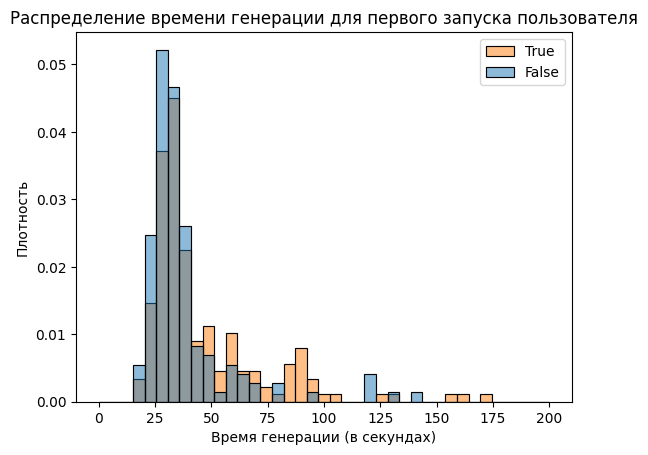

In [24]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Чтение данных из файла
data = pd.read_csv('data.tsv', sep='\t')

data['event_timestamp'] = pd.to_datetime(data['event_timestamp'])

# Фильтрация данных после 20 мая
data = data[data['event_timestamp'] > '2023-05-20']

# Создание столбца 'two_or_more_generations' для определения, было ли у пользователя две или более генерации
data['two_or_more_generations'] = data.groupby('user_id')['event_name'].transform(lambda x: len(x[x == 'generate']) >= 2)

sns.histplot(data, x="generation_time", hue="two_or_more_generations", stat="density", common_norm=False, binrange=(0, 200))

plt.title("Распределение времени генерации для первого запуска пользователя")
plt.xlabel("Время генерации (в секундах)")
plt.ylabel("Плотность")
plt.legend(["True", "False"])

plt.show()


### Вывод

По графику можно предположить, что пользователи, которые ждут более 35 секунд, склонны отказываться от дальнейшей генерации.Введение нового сообщения на экране генерации с уведомлением о времени ожидания до одной минуты может помочь в улучшении конверсии, поскольку пользователи будут осведомлены о предполагаемом времени ожидания.

(Разница в конверсии на большом времени значительна, это может указывать на то, что пользователи, уже ожидавшие длительное время при первом запуске, менее склонны к повторной генерации.)